<a href="https://colab.research.google.com/github/nguyenfan20/Traffic_SGU/blob/main/Vietnamese_Legal_Traffic_RAG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tổng quan dự án 🤖

Notebook này trình bày cách tạo một chatbot bằng hệ thống RAG dựa vào thư viện LangChain và LLMs

In [1]:
!pip uninstall -y fsspec datasets gcsfs
!pip install fsspec==2024.12.0 datasets==3.5.0 gcsfs==2024.12.0
!pip install -q torch transformers accelerate bitsandbytes \
  langchain sentence-transformers faiss-cpu openpyxl pacmap datasets \
  langchain-community ragatouille tqdm pymupdf python-docx pandas

Found existing installation: fsspec 2025.3.2
Uninstalling fsspec-2025.3.2:
  Successfully uninstalled fsspec-2025.3.2
Found existing installation: datasets 2.14.4
Uninstalling datasets-2.14.4:
  Successfully uninstalled datasets-2.14.4
Found existing installation: gcsfs 2025.3.2
Uninstalling gcsfs-2025.3.2:
  Successfully uninstalled gcsfs-2025.3.2
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 16.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 40.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you 

In [2]:
import os
from tqdm.notebook import tqdm
import pandas as pd
from typing import Optional, List, Tuple

FILE_01 = '/content/luatgt.pdf'


VECTOR_DATABASE_PATH = '/content/vectordatabase'
os.makedirs('/content/vectordatabase', exist_ok=True)

# Chunking 🔪

In [3]:
from langchain.docstore.document import Document as LangchainDocument
from tqdm import tqdm
from langchain.document_loaders import PyMuPDFLoader
from docx import Document as DocxDocument
import pandas as pd
import os

def load_pdf_file(file_path):
    """Loads a PDF file and returns its entire content using PyMuPDFLoader."""
    loader = PyMuPDFLoader(file_path)
    documents = loader.load()
    full_content = ""
    for doc in documents:
        full_content += doc.page_content + "\n"  # Add a newline to separate pages
    return full_content  # Return the entire content

def load_txt_file(file_path):
    """Loads a TXT file and returns its content as a string."""
    with open(file_path, 'r', encoding='utf-8') as file:
        return file.read()

def load_docx_file(file_path):
    """Loads a DOCX file and returns its content as a string."""
    doc = DocxDocument(file_path)
    full_text = []
    for para in doc.paragraphs:
        full_text.append(para.text)
    return "\n".join(full_text)

def load_csv_file(file_path):
    """Loads a CSV file and concatenates all rows as a single string."""
    df = pd.read_csv(file_path)
    return df.to_string(index=False)  # Converts the DataFrame to a string (without row indices)

def load_file(file_path):
    """Determines the file type and loads the file content."""
    ext = os.path.splitext(file_path)[1].lower()
    if ext == '.txt':
        return load_txt_file(file_path)
    elif ext in ['.doc', '.docx']:
        return load_docx_file(file_path)
    elif ext == '.pdf':
        return load_pdf_file(file_path)
    elif ext == '.csv':
        return load_csv_file(file_path)
    else:
        raise ValueError(f"Unsupported file type: {ext}")

In [4]:
# List of document file paths (PDF, DOCX, TXT, CSV)
file_paths = [FILE_01] # Example file paths. It can be like: file_paths = [FILE_01, FILE_02,..]

RAW_KNOWLEDGE_BASE = []
for file_path in tqdm(file_paths):
    try:
        content = load_file(file_path)
        RAW_KNOWLEDGE_BASE.append(
            LangchainDocument(page_content=content, metadata={"source": file_path})
        )
    except Exception as e:
        print(f"Failed to process {file_path}: {e}")

100%|██████████| 1/1 [00:03<00:00,  3.07s/it]


In [5]:
for doc in RAW_KNOWLEDGE_BASE:
    print(f"Source: {doc.metadata['source']}")
    print(f"Content snippet: {doc.page_content[:500]}...\n")

Source: /content/luatgt.pdf
Content snippet: CHÍNH PHỦ
--------
CỘNG HÒA XÃ HỘI CHỦNGHĨA VIỆT NAM
Độc lập - Tựdo - Hạnh phúc
---------------
Số: 168/2024/NĐ-CP
Hà Nội, ngày 26 tháng 12 năm 2024
NGHỊĐỊNH
QUY ĐỊNH XỬPHẠT VI PHẠM HÀNH CHÍNH VỀTRẬT TỰ, AN TOÀN GIAO
THÔNG TRONG LĨNH VỰC GIAO THÔNG ĐƯỜNG BỘ; TRỪĐIỂM, PHỤC HỒI
ĐIỂM GIẤY PHÉP LÁI XE
Căn cứLuật Tổchức Chính phủngày 19 tháng 6 năm 2015; Luật sửa đổi, bổsung một
sốđiều của Luật Tổchức Chính phủvà Luật Tổchức chính quyền địa phương ngày 22
tháng 11 năm 2019;
Căn cứLuật Xửlý vi phạm hà...



In [6]:
from langchain.text_splitter import RecursiveCharacterTextSplitter

# We use a hierarchical list of separators specifically tailored for splitting Markdown documents
# This list is taken from LangChain's MarkdownTextSplitter class
MARKDOWN_SEPARATORS = [
    "\n#{1,6} ",
    "```\n",
    "\n\\*\\*\\*+\n",
    "\n---+\n",
    "\n___+\n",
    "\n\n",
    "\n",
    " ",
    "",
]

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=1000,  # The maximum number of characters in a chunk: we selected this value arbitrarily
    chunk_overlap=100,  # The number of characters to overlap between chunks
    add_start_index=True,  # If `True`, includes chunk's start index in metadata
    strip_whitespace=True,  # If `True`, strips whitespace from the start and end of every document
    separators=MARKDOWN_SEPARATORS,
)

docs_processed = []
for doc in RAW_KNOWLEDGE_BASE:
    docs_processed += text_splitter.split_documents([doc])
print(docs_processed[1])

page_content='Chương I
NHỮNG QUY ĐỊNH CHUNG
Điều 1. Phạm vi điều chỉnh
1. Nghịđịnh này quy định về:
a) Xửphạt vi phạm hành chính vềtrật tự, an toàn giao thông trong lĩnh vực giao thông
đường bộbao gồm: hành vi vi phạm hành chính; hình thức, mức xửphạt, biện pháp khắc
phục hậu quảđối với từng hành vi vi phạm hành chính; thẩm quyền lập biên bản, thẩm
quyền xửphạt, mức phạt tiền cụthểtheo từng chức danh đối với hành vi vi phạm hành
chính vềtrật tự, an toàn giao thông trong lĩnh vực giao thông đường bộ;
b) Mức trừđiểm giấy phép lái xe đối với từng hành vi vi phạm hành chính; trình tự, thủ
tục, thẩm quyền trừđiểm, phục hồi điểm giấy phép lái xe đểquản lý việc chấp hành pháp
luật vềtrật tự, an toàn giao thông đường bộcủa người lái xe.
2. Các hành vi vi phạm hành chính trong lĩnh vực quản lý nhà nước khác liên quan đến
trật tự, an toàn giao thông trong lĩnh vực giao thông đường bộmà không quy định tại
Nghịđịnh này thì áp dụng quy định tại các Nghịđịnh quy định vềxửphạt vi phạm hành' metadata=

# Embedding document 📂

In [7]:
from langchain.text_splitter import RecursiveCharacterTextSplitter
from transformers import AutoTokenizer

EMBEDDING_MODEL_NAME = "AITeamVN/Vietnamese_Embedding"


def split_documents(
    chunk_size: int,
    knowledge_base: List[LangchainDocument],
    tokenizer_name: Optional[str] = EMBEDDING_MODEL_NAME,
) -> List[LangchainDocument]:
    """
    Split documents into chunks of maximum size `chunk_size` tokens and return a list of documents.
    """
    text_splitter = RecursiveCharacterTextSplitter.from_huggingface_tokenizer(
        AutoTokenizer.from_pretrained(tokenizer_name),
        chunk_size=chunk_size,
        chunk_overlap=int(chunk_size / 10),
        add_start_index=True,
        strip_whitespace=True,
        separators=MARKDOWN_SEPARATORS,
    )

    docs_processed = []
    for doc in knowledge_base:
        docs_processed += text_splitter.split_documents([doc])

    # Remove duplicates
    unique_texts = {}
    docs_processed_unique = []
    for doc in docs_processed:
        if doc.page_content not in unique_texts:
            unique_texts[doc.page_content] = True
            docs_processed_unique.append(doc)

    return docs_processed_unique


docs_processed = split_documents(
    258,  # We choose a chunk size adapted to our model
    RAW_KNOWLEDGE_BASE,
    tokenizer_name=EMBEDDING_MODEL_NAME,
)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.20k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

# Vector Database 📂

In [8]:
import os
from langchain.vectorstores import FAISS
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores.utils import DistanceStrategy

embedding_model = HuggingFaceEmbeddings(
    model_name=EMBEDDING_MODEL_NAME,
    multi_process=True,
    model_kwargs={"device": "cuda"},
    encode_kwargs={"normalize_embeddings": True}
)

KNOWLEDGE_VECTOR_DATABASE = FAISS.from_documents(
    docs_processed, embedding_model, distance_strategy=DistanceStrategy.COSINE
)


<ipython-input-8-a460f51192b9>:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.51k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/708 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.27G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/297 [00:00<?, ?B/s]

# Lưu Vector Database được xử lý vào các thư mục

In [9]:
import faiss  # Make sure to import FAISS
import pickle

# Save the FAISS index to a file
faiss_file_path = os.path.join(VECTOR_DATABASE_PATH, 'faiss_index.bin')
faiss.write_index(KNOWLEDGE_VECTOR_DATABASE.index, faiss_file_path)
print(f"FAISS index saved to {faiss_file_path}")

# Save the document store to a pickle file
docstore_file_path = os.path.join(VECTOR_DATABASE_PATH, 'docstore.pkl')
with open(docstore_file_path, 'wb') as f:
    pickle.dump(KNOWLEDGE_VECTOR_DATABASE.docstore, f)
print(f"Document store saved to {docstore_file_path}")

# Save the index_to_docstore_id mapping
mapping_file_path = os.path.join(VECTOR_DATABASE_PATH, 'index_to_docstore_id.pkl')
with open(mapping_file_path, 'wb') as f:
    pickle.dump(KNOWLEDGE_VECTOR_DATABASE.index_to_docstore_id, f)
print(f"Index to document store ID mapping saved to {mapping_file_path}")

# Load the FAISS index from the file
loaded_index = faiss.read_index(faiss_file_path)

# Load the document store from the pickle file
with open(docstore_file_path, 'rb') as f:
    loaded_docstore = pickle.load(f)

# Load the index_to_docstore_id mapping
with open(mapping_file_path, 'rb') as f:
    index_to_docstore_id = pickle.load(f)

# Create the FAISS vector store using the loaded index and document store
loaded_vector_database = FAISS(
    index=loaded_index,
    docstore=loaded_docstore,
    index_to_docstore_id=index_to_docstore_id,
    embedding_function=embedding_model.embed_query
)
print("Vector database loaded successfully.")

FAISS index saved to /content/vectordatabase/faiss_index.bin
Document store saved to /content/vectordatabase/docstore.pkl
Index to document store ID mapping saved to /content/vectordatabase/index_to_docstore_id.pkl
Vector database loaded successfully.


# Chain với thư mục đã lưu

In [10]:
# Embed a user query in the same space
user_query = "Quy định về độ tuổi lái xe mô tô hai bánh?"
query_vector = embedding_model.embed_query(user_query)

In [11]:
print(f"\nStarting retrieval for {user_query=}...")
# retrieved_docs = KNOWLEDGE_VECTOR_DATABASE.similarity_search(query=user_query, k=5)

retrieved_docs = loaded_vector_database.similarity_search(query=user_query, k=5)

print(
    "\n==================================Top document=================================="
)
print(retrieved_docs[0].page_content)
print("==================================Metadata==================================")
print(retrieved_docs[0].metadata)


Starting retrieval for user_query='Quy định về độ tuổi lái xe mô tô hai bánh?'...

==================================Top document==================================
Giao thông đường bộnăm 1968 cấp (trừgiấy phép lái xe quốc tếdo Việt Nam cấp)
nhưng không mang theo giấy phép lái xe quốc gia phù hợp với loại xe được phép điều
khiển;
c) Sửdụng giấy phép lái xe không hợp lệ(giấy phép lái xe có sốphôi ghi ởmặt sau
không trùng với sốphôi được cấp mới nhất trong hệthống thông tin quản lý giấy phép lái
xe).
6. Phạt tiền từ4.000.000 đồng đến 6.000.000 đồng đối với người từđủ16 tuổi đến dưới
18 tuổi điều khiển xe ô tô, xe chởngười bốn bánh có gắn động cơ, xe chởhàng bốn bánh
có gắn động cơ và các loại xe tương tựxe ô tô.
7. Phạt tiền từ6.000.000 đồng đến 8.000.000 đồng đối với người điều khiển xe mô tô hai
bánh có dung tích xi-lanh trên 125 cm3 trởlên hoặc có công suất động cơ điện trên 11
kW, xe mô tô ba bánh thực hiện một trong các hành vi vi phạm sau đây:
a) Có giấy phép lái xe nhưng không phù

# Đưa LLM để tạo sinh câu trả lời với dữ liệu được chain

In [12]:
from huggingface_hub import login
login()


In [13]:
from transformers import pipeline, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch

READER_MODEL_NAME = "HuggingFaceH4/zephyr-7b-beta"

# Cấu hình bitsandbytes để tải mô hình ở định dạng 4-bit tiết kiệm RAM
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.float16,  # Đổi sang float16 nếu bfloat16 không được hỗ trợ
)

# Load mô hình với cấu hình nhẹ, tự động phân bổ thiết bị (GPU/CPU)
model = AutoModelForCausalLM.from_pretrained(
    READER_MODEL_NAME,
    quantization_config=bnb_config,
    device_map="auto",
    trust_remote_code=True
)

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(READER_MODEL_NAME)

# Tạo pipeline để dùng mô hình như 1 RAG Reader
READER_LLM = pipeline(
    model=model,
    tokenizer=tokenizer,
    task="text-generation",
    do_sample=True,
    temperature=0.2,
    repetition_penalty=1.1,
    return_full_text=False,
    max_new_tokens=500,
)


config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.9k [00:00<?, ?B/s]

Fetching 8 files:   0%|          | 0/8 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not in

model-00002-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00004-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

model-00003-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00005-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00007-of-00008.safetensors:   0%|          | 0.00/1.98G [00:00<?, ?B/s]

model-00001-of-00008.safetensors:   0%|          | 0.00/1.89G [00:00<?, ?B/s]

model-00008-of-00008.safetensors:   0%|          | 0.00/816M [00:00<?, ?B/s]

model-00006-of-00008.safetensors:   0%|          | 0.00/1.95G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/111 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.43k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.80M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/42.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/168 [00:00<?, ?B/s]

Device set to use cuda:0


In [14]:
!pip -q install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 43.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [15]:
from langdetect import detect

prompt_in_chat_format_en = [
    {
        "role": "system",
        "content": """Using the information contained in the context,
give a comprehensive answer to the question.
Respond only to the question asked, response should be concise and relevant to the question.
Provide the number of the source document when relevant.
If the answer cannot be deduced from the context, do not give an answer.""",
    },
    {
        "role": "user",
        "content": """Context:
{context}
---
Now here is the question you need to answer.

Question: {question}""",
    },
]

# Prompt template for Vietnamese
prompt_in_chat_format_vi = [
    {
        "role": "system",
        "content": """Sử dụng thông tin trong ngữ cảnh, hãy đưa ra câu trả lời đầy đủ cho câu hỏi.
Chỉ trả lời câu hỏi được hỏi, câu trả lời cần ngắn gọn và phù hợp với câu hỏi.
Cung cấp số của tài liệu nguồn khi phù hợp.
Nếu câu trả lời không thể suy ra từ ngữ cảnh, không đưa ra câu trả lời.""",
    },
    {
        "role": "user",
        "content": """Ngữ cảnh:
{context}
---
Bây giờ đây là câu hỏi mà bạn cần trả lời.

Câu hỏi: {question}""",
    },
]

def detect_language(query):
    return detect(query)

def create_prompt(question):

    language = detect_language(question)

    if language == 'vi':
        RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
            prompt_in_chat_format_vi, tokenize=False, add_generation_prompt=True
        )
    else:
        RAG_PROMPT_TEMPLATE = tokenizer.apply_chat_template(
            prompt_in_chat_format_en, tokenize=False, add_generation_prompt=True
        )

    return RAG_PROMPT_TEMPLATE

#test prompt if the question is Vietnamese

test_prompt = create_prompt("Hà Nội là thủ đô của nước nào?")
print(test_prompt)

<|system|>
Sử dụng thông tin trong ngữ cảnh, hãy đưa ra câu trả lời đầy đủ cho câu hỏi.
Chỉ trả lời câu hỏi được hỏi, câu trả lời cần ngắn gọn và phù hợp với câu hỏi.
Cung cấp số của tài liệu nguồn khi phù hợp.
Nếu câu trả lời không thể suy ra từ ngữ cảnh, không đưa ra câu trả lời.</s>
<|user|>
Ngữ cảnh:
{context}
---
Bây giờ đây là câu hỏi mà bạn cần trả lời.

Câu hỏi: {question}</s>
<|assistant|>



In [16]:
retrieved_docs_text = [
    doc.page_content for doc in retrieved_docs
]  # We only need the text of the documents
context = "\nExtracted documents:\n"
context += "".join(
    [f"Document {str(i)}:::\n" + doc for i, doc in enumerate(retrieved_docs_text)]
)

user_query="Quy định về độ tuổi lái xe mô tô 2 bánh?"

rag_prompt = create_prompt(user_query)
final_prompt = rag_prompt.format(
    question=user_query, context=context
)

# Redact an answer
answer = READER_LLM(final_prompt)[0]["generated_text"]
print(answer)

Câu trả lời: Người dưới 16 tuổi không được điều khiển xe mô tô 2 bánh, ngoài trường hợp người được giấy phép lái xe mô tô 2 bánh phù hợp với loại xe đang điều khiển (Document 0). Người từ 16 đến 18 tuổi có giấy phép lái xe mô tô 2 bánh, nhưng không mang theo giấy phép lái xe có sốphôi ghi ởmặt sau không trùng với sốphôi được cấp mới nhất trong hệ thống quản lý giấy phép lái xe (Document 0). Phạt tiền từ 4.000.000 đồng đến 6.000.000 đồng đối với người từ 16 đến 18 tuổi điều khiển xe mô tô 2 bánh (Document 1).


In [17]:
from transformers import pipeline, Pipeline

def answer_with_rag(
    question: str,
    llm: Pipeline,
    knowledge_index: FAISS,
    num_retrieved_docs: int = 30,
    num_docs_final: int = 5,
) -> Tuple[str, List[LangchainDocument]]:

    print("=> Retrieving documents...")
    relevant_docs = knowledge_index.similarity_search(query=question, k=num_retrieved_docs)

    if not relevant_docs:
        raise ValueError("No relevant documents retrieved.")

    # Giữ bản gốc để return
    retrieved_docs = relevant_docs[:num_docs_final]  # giữ lại LangchainDocument gốc

    # Lấy nội dung text để đưa vào prompt
    docs_text = [doc.page_content for doc in retrieved_docs]

    context = "\nExtracted documents:\n"
    context += "".join(
        [f"Document {str(i)}:::\n{doc}" for i, doc in enumerate(docs_text)]
    )

    RAG_PROMPT_TEMPLATE = create_prompt(question)
    final_prompt = RAG_PROMPT_TEMPLATE.format(question=question, context=context)

    print("=> Generating answer...")
    answer = llm(final_prompt)[0]["generated_text"]

    return answer, retrieved_docs

In [18]:
question = "Nguyên tắc trừ điểm giấy phép lái xe với giấy phép lái xe không giới hạn?"

answer, relevant_docs = answer_with_rag(
    question, READER_LLM, loaded_vector_database)

=> Retrieving documents...
=> Generating answer...


In [19]:
print("==================================Answer==================================")
print(f"{answer}")
print("==================================Source docs==================================")
for i, doc in enumerate(relevant_docs):
    print(f"Document {i}------------------------------------------------------------")
    print(doc)

==================================Answer==================================
Nguyên tắc trừ điểm giấy phép lái xe có áp dụng với giấy phép lái xe không giới hạn, nhưng chỉ áp dụng khi người điều khiển xe mô tô, xe tương tựxe mô tô hoặc trừ điểm giấy phép lái xe có thời hạn (xe ô tô, xe tương tựxe ô tô, xe chởngười bốn bánh có gắn động cơ, xe chởhàng bốn bánh có gắn động cơ) khi người điều khiển xe ô tô, xe tương tựxe ô tô, xe chởngười bốn bánh có gắn động cơ, xe chởhàng bốn bánh có gắn động cơ bị xửphạt vi phạm hành chính. Nếu người điều khiển xe mô tô, xe tương tựxe mô tô bị xửphạt vi phạm hành chính, chỉ áp dụng trừ điểm giấy phép lái xe khi người điều khiển xe mô tô, xe tương tựxe mô tô bị xửphạt vi phạm hành chính có quy định trừ điểm giấy phép lái xe. Nguyên tắc nà được quy định tại Điều 7 của người điều khiển
==================================Source docs==================================
Document 0------------------------------------------------------------
page_content='GIẤY PHÉP 

In [20]:
!pip -q install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 21.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.5 MB/s eta 0:00:00


In [21]:
import gradio as gr

# Hàm xử lý RAG trong giao diện chat
def gr_rag_chat(question, history):
    try:
        # Truy xuất tài liệu liên quan
        relevant_docs = loaded_vector_database.similarity_search(question, k=5)
        if not relevant_docs:
            return "", history + [(question, "❌ Không tìm thấy tài liệu phù hợp.")]

        # Kết hợp nội dung các tài liệu
        context = "\n".join(
            [f"[Tài liệu {i+1}]\n" + doc.page_content for i, doc in enumerate(relevant_docs)]
        )

        # Tạo prompt cho LLM
        rag_prompt = create_prompt(question)
        final_prompt = rag_prompt.format(question=question, context=context)

        # Sinh câu trả lời từ mô hình
        answer = READER_LLM(final_prompt)[0]["generated_text"]

        # Trả về kết quả và cập nhật lịch sử chat
        history.append((question, answer))
        return "", history

    except Exception as e:
        return "", history + [(question, f"⚠️ Lỗi: {str(e)}")]

# Giao diện Gradio dạng Blocks
with gr.Blocks() as demo:
    gr.Markdown("## 🤖 Hệ thống Hỏi - Đáp RAG về Luật Giao Thông")
    chatbot = gr.Chatbot(label="📚 Đối thoại RAG")
    msg = gr.Textbox(label="💬 Nhập câu hỏi của bạn", placeholder="Ví dụ: Không đội mũ bảo hiểm bị phạt bao nhiêu?")

    msg.submit(fn=gr_rag_chat, inputs=[msg, chatbot], outputs=[msg, chatbot])

# Khởi chạy giao diện
demo.launch(share=True)


<ipython-input-21-027cea557b7e>:33: UserWarning: You have not specified a value for the `type` parameter. Defaulting to the 'tuples' format for chatbot messages, but this is deprecated and will be removed in a future version of Gradio. Please set type='messages' instead, which uses openai-style dictionaries with 'role' and 'content' keys.
  chatbot = gr.Chatbot(label="📚 Đối thoại RAG")


Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://9e3305eb8518e72186.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [22]:
EVAL_CSV_FILE = "test.csv"  # Đường dẫn đến file CSV chứa bộ đánh giá

def load_evaluation_data(csv_file_path: str) -> pd.DataFrame:
    """Loads the evaluation data from a CSV file."""
    return pd.read_csv(csv_file_path, encoding='utf-8')

def evaluate_answer(
    question: str,
    ground_truth: str,
    rag_answer: str,
    relevant_docs: List[LangchainDocument],
) -> dict:
    """
    Evaluates the RAG answer based on several criteria.
    This is where you implement your detailed evaluation logic.
    """

    evaluation = {}

    # 1. Correctness (Tính đúng đắn)
    correctness_keywords = 0
    ground_truth_keywords = ground_truth.lower().split()
    for keyword in ground_truth_keywords:
        if keyword in rag_answer.lower():
            correctness_keywords += 1
    evaluation["correctness"] = min(5, correctness_keywords)  # Scale to 1-5

    # 2. Relevance (Tính liên quan)
    # Đếm số document được retrieved có chứa các keyword từ ground truth
    relevant_doc_count = 0
    for doc in relevant_docs:
        if any(keyword in doc.page_content.lower() for keyword in ground_truth_keywords):
            relevant_doc_count += 1
    evaluation["relevance"] = min(5, relevant_doc_count)

    # 3. Completeness (Tính đầy đủ)
    completeness_score = len(rag_answer) / len(ground_truth) if len(ground_truth) > 0 else 1
    evaluation["completeness"] = min(5, int(completeness_score * 5))

    # 4. Conciseness (Tính trôi chảy)
    evaluation["conciseness"] = 5 if len(rag_answer) <= len(ground_truth) * 1.2 else 3

    return evaluation

def main_evaluation(
    llm: Pipeline,
    knowledge_index: FAISS,
    eval_csv_path: str,
    num_retrieved_docs: int = 10,
    num_docs_final: int = 3,
):
    """
    Main evaluation loop.
    """

    eval_data = load_evaluation_data(eval_csv_path)
    eval_results = []

    for index, row in tqdm(eval_data.iterrows(), total=len(eval_data)):
        question = row["question"]
        ground_truth = row["ground_truth_answer"]

        try:
            rag_answer, retrieved_docs = answer_with_rag(
                question, llm, knowledge_index, num_retrieved_docs, num_docs_final
            )
        except ValueError as e:
            print(f"Error processing question: {question} - {e}")
            eval_results.append(
                {"question": question, "ground_truth": ground_truth, "error": str(e)}
            )
            continue

        evaluation = evaluate_answer(question, ground_truth, rag_answer, retrieved_docs)
        evaluation["question"] = question
        evaluation["ground_truth"] = ground_truth
        evaluation["rag_answer"] = rag_answer

        eval_results.append(evaluation)

    # Convert results to DataFrame for easier analysis
    results_df = pd.DataFrame(eval_results)
    results_df.to_csv("rag_evaluation_results.csv", encoding="utf-8", index=False)
    print("Evaluation completed. Results saved to 'rag_evaluation_results.csv'")

# Chạy đánh giá
if __name__ == "__main__":
    main_evaluation(
        READER_LLM,
        loaded_vector_database,
        EVAL_CSV_FILE,
        num_retrieved_docs=20,
        num_docs_final=5,
    )

  0%|          | 0/10 [00:00<?, ?it/s]

=> Retrieving documents...
=> Generating answer...


 10%|█         | 1/10 [01:16<11:25, 76.20s/it]

=> Retrieving documents...
=> Generating answer...


 20%|██        | 2/10 [01:42<06:15, 46.92s/it]

=> Retrieving documents...
=> Generating answer...


 30%|███       | 3/10 [02:17<04:50, 41.50s/it]

=> Retrieving documents...
=> Generating answer...


 40%|████      | 4/10 [02:41<03:28, 34.69s/it]

=> Retrieving documents...
=> Generating answer...


 50%|█████     | 5/10 [03:37<03:31, 42.37s/it]

=> Retrieving documents...
=> Generating answer...


 60%|██████    | 6/10 [04:10<02:36, 39.03s/it]

=> Retrieving documents...
=> Generating answer...


 70%|███████   | 7/10 [05:06<02:13, 44.46s/it]

=> Retrieving documents...
=> Generating answer...


 80%|████████  | 8/10 [05:28<01:15, 37.56s/it]

=> Retrieving documents...


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


=> Generating answer...


 90%|█████████ | 9/10 [05:58<00:35, 35.22s/it]

=> Retrieving documents...
=> Generating answer...


100%|██████████| 10/10 [06:55<00:00, 41.55s/it]

Evaluation completed. Results saved to 'rag_evaluation_results.csv'


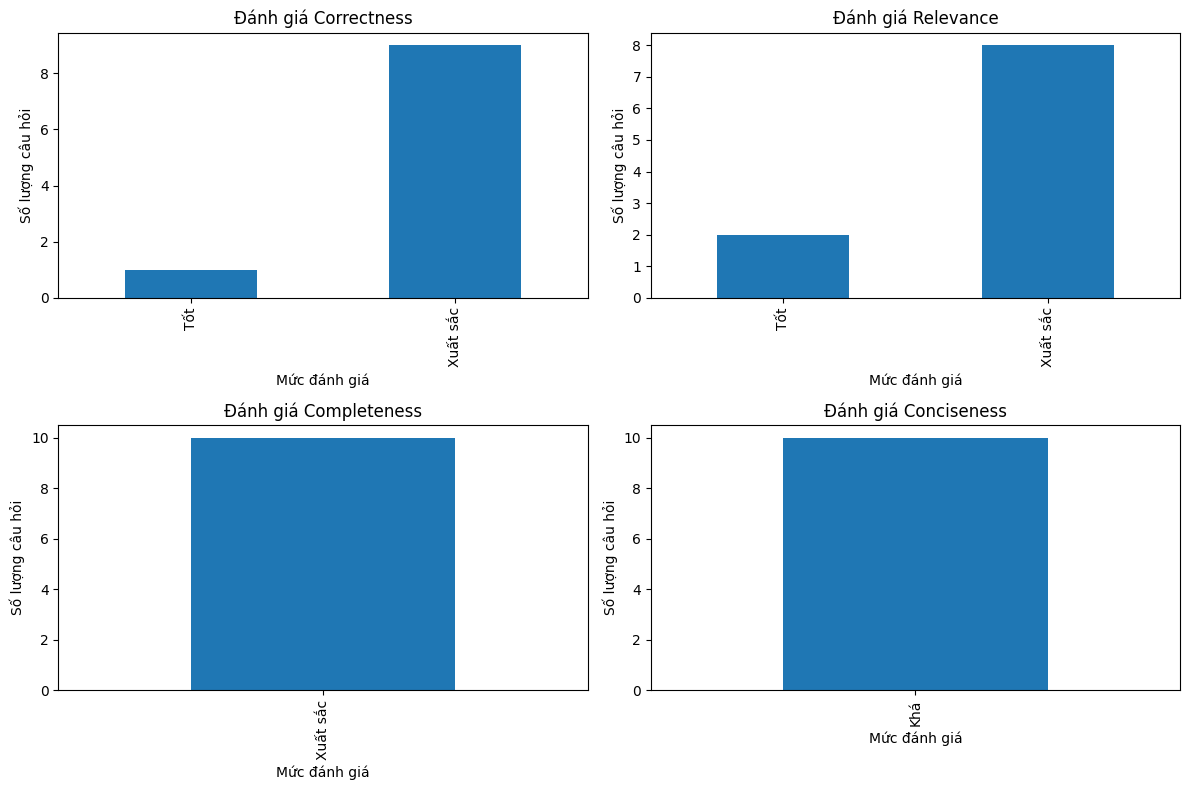

Thống kê đánh giá Correctness:
 danh_gia_correctness
Xuất sắc    9
Tốt         1
Name: count, dtype: int64

Thống kê đánh giá Relevance:
 danh_gia_relevance
Xuất sắc    8
Tốt         2
Name: count, dtype: int64

Thống kê đánh giá Completeness:
 danh_gia_completeness
Xuất sắc    10
Name: count, dtype: int64

Thống kê đánh giá Conciseness:
 danh_gia_conciseness
Khá    10
Name: count, dtype: int64


In [23]:
import pandas as pd
import matplotlib.pyplot as plt

# 1. Đọc dữ liệu từ file CSV
df = pd.read_csv("rag_evaluation_results.csv")

# 2. Định nghĩa thang điểm (ví dụ)
thang_diem = {
    5: "Xuất sắc",
    4: "Tốt",
    3: "Khá",
    2: "Trung bình",
    1: "Kém"
}

# 3. Ánh xạ điểm số vào thang điểm
def danh_gia_theo_thang_diem(diem):
    for muc_diem, danh_gia in thang_diem.items():
        if diem >= muc_diem:
            return danh_gia
    return "Kém"  # Mặc định nếu không có mức nào phù hợp

df["danh_gia_correctness"] = df["correctness"].apply(danh_gia_theo_thang_diem)
df["danh_gia_relevance"] = df["relevance"].apply(danh_gia_theo_thang_diem)
df["danh_gia_completeness"] = df["completeness"].apply(danh_gia_theo_thang_diem)
df["danh_gia_conciseness"] = df["conciseness"].apply(danh_gia_theo_thang_diem)

# 4. Thống kê số lượng đánh giá cho từng mức
thong_ke_correctness = df["danh_gia_correctness"].value_counts()
thong_ke_relevance = df["danh_gia_relevance"].value_counts()
thong_ke_completeness = df["danh_gia_completeness"].value_counts()
thong_ke_conciseness = df["danh_gia_conciseness"].value_counts()

# 5. Trực quan hóa bằng biểu đồ cột
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
thong_ke_correctness.sort_index().plot(kind="bar")
plt.title("Đánh giá Correctness")
plt.xlabel("Mức đánh giá")
plt.ylabel("Số lượng câu hỏi")

plt.subplot(2, 2, 2)
thong_ke_relevance.sort_index().plot(kind="bar")
plt.title("Đánh giá Relevance")
plt.xlabel("Mức đánh giá")
plt.ylabel("Số lượng câu hỏi")

plt.subplot(2, 2, 3)
thong_ke_completeness.sort_index().plot(kind="bar")
plt.title("Đánh giá Completeness")
plt.xlabel("Mức đánh giá")
plt.ylabel("Số lượng câu hỏi")

plt.subplot(2, 2, 4)
thong_ke_conciseness.sort_index().plot(kind="bar")
plt.title("Đánh giá Conciseness")
plt.xlabel("Mức đánh giá")
plt.ylabel("Số lượng câu hỏi")

plt.tight_layout()  # Để các biểu đồ không bị chồng chéo
plt.show()

# 6. In ra thống kê dạng bảng (tùy chọn)
print("Thống kê đánh giá Correctness:\n", thong_ke_correctness)
print("\nThống kê đánh giá Relevance:\n", thong_ke_relevance)
print("\nThống kê đánh giá Completeness:\n", thong_ke_completeness)
print("\nThống kê đánh giá Conciseness:\n", thong_ke_conciseness)

In [ ]:
import os
os.kill(os.getpid(), 9)
